# 高度な取引戦略分析 - Advanced Trading Strategies Analysis

このノートブックでは、LME銅先物データを使用して、より高度な取引戦略と市場分析を実施します。

## 分析の概要
1. **スプレッド取引戦略分析** - 期間構造を利用した裁定取引機会の特定
2. **季節性・循環性分析** - 市場の時間的パターンと周期性の分析
3. **相関構造分析** - 異なる限月間の相関関係とポートフォリオへの影響
4. **リスク・パリティ分析** - 最適なポートフォリオ構築手法
5. **異常検知・レジーム分析** - 市場の構造変化と異常値の検出

In [ ]:
from config.database_config import get_connection_string
import sys
import os
import pandas as pd

import numpy as np

import pyodbc

from datetime import datetime, timedelta

import matplotlib.pyplot as plt

import matplotlib.dates as mdates

from matplotlib.gridspec import GridSpec

import seaborn as sns
from scipy import stats

import warnings


# プロジェクトルートをPythonパスに追加

project_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))

sys.path.insert(0, project_root)



warnings.filterwarnings('ignore')


# 英語フォント設定（文字化け回避）

plt.rcParams['font.family'] = 'Arial'

plt.rcParams['font.size'] = 10

plt.rcParams['figure.figsize'] = (12, 8)

plt.rcParams['figure.dpi'] = 120


# カラーパレット

COLORS = {

    'primary': '#1f77b4',

    'secondary': '#ff7f0e',

    'tertiary': '#2ca02c',

    'quaternary': '#d62728',

    'quinary': '#9467bd'

}


print("ライブラリの読み込み完了")

ライブラリの読み込み完了


## データ読み込みと前処理

In [ ]:
def load_futures_data(conn, days=365):
    """銅先物データの読み込み"""
    query = f"""
    SELECT 
        p.TradeDate,
        t.TenorTypeName,
        p.SettlementPrice as ClosePrice,
        p.Volume,
        p.OpenInterest,
        CASE 
            WHEN t.TenorTypeName LIKE 'Generic 1st%' THEN 1
            WHEN t.TenorTypeName LIKE 'Generic 2nd%' THEN 2
            WHEN t.TenorTypeName LIKE 'Generic 3rd%' THEN 3
            WHEN t.TenorTypeName LIKE 'Generic 4th%' THEN 4
            WHEN t.TenorTypeName LIKE 'Generic 5th%' THEN 5
            WHEN t.TenorTypeName LIKE 'Generic 6th%' THEN 6
            WHEN t.TenorTypeName LIKE 'Generic 7th%' THEN 7
            WHEN t.TenorTypeName LIKE 'Generic 8th%' THEN 8
            WHEN t.TenorTypeName LIKE 'Generic 9th%' THEN 9
            WHEN t.TenorTypeName LIKE 'Generic 10th%' THEN 10
            WHEN t.TenorTypeName LIKE 'Generic 11th%' THEN 11
            WHEN t.TenorTypeName LIKE 'Generic 12th%' THEN 12
            ELSE NULL
        END as TenorNumber
    FROM T_CommodityPrice p
    INNER JOIN M_Metal m ON p.MetalID = m.MetalID
    INNER JOIN M_TenorType t ON p.TenorTypeID = t.TenorTypeID
    WHERE 
        m.MetalCode = 'COPPER'
        AND p.TradeDate >= DATEADD(day, -{days}, GETDATE())
        AND p.SettlementPrice IS NOT NULL
    ORDER BY p.TradeDate DESC
    """

    df = pd.read_sql(query, conn)
    df['TradeDate'] = pd.to_datetime(df['TradeDate'])
    df = df.dropna(subset=['TenorNumber'])
    return df


# データベース接続とデータ読み込み
conn = pyodbc.connect(get_connection_string())
df = load_futures_data(conn, days=365)

# ピボットテーブル作成
price_pivot = df.pivot_table(values='ClosePrice', index='TradeDate',
                             columns='TenorNumber', aggfunc='mean').sort_index()
volume_pivot = df.pivot_table(
    values='Volume', index='TradeDate', columns='TenorNumber', aggfunc='mean').sort_index()

# 利用可能な限月の取得
available_tenors = sorted(
    [col for col in price_pivot.columns if not pd.isna(col)])

print(
    f"データ期間: {df['TradeDate'].min().date()} - {df['TradeDate'].max().date()}")
print(f"データ件数: {len(df):,}件")
print(f"利用可能限月: {available_tenors}")
print(f"価格データサイズ: {price_pivot.shape}")

データ期間: 2024-07-05 - 2025-07-04
データ件数: 2,526件
利用可能限月: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 9.0, 10.0, 11.0, 12.0]
価格データサイズ: (253, 10)


## 1. スプレッド取引戦略分析

### 分析目的
異なる限月間の価格差（スプレッド）を利用した裁定取引機会を特定し、リスクとリターンを評価します。期間構造の歪みを利用した統計的裁定取引の可能性を探ります。

### 分析手法
- **カレンダースプレッド計算**: 近限月と遠限月の価格差を算出
- **統計的性質分析**: スプレッドの平均、標準偏差、分布特性を分析
- **平均回帰性検証**: スプレッドが歴史的水準に回帰する傾向を確認
- **リスク調整後リターン**: シャープレシオによる効率性評価

### グラフの見方・解釈
- **正のスプレッド**: コンタンゴ状態（遠限月 > 近限月）- 通常の市場状況
- **負のスプレッド**: バックワーデーション状態（近限月 > 遠限月）- 需給逼迫
- **スプレッドの変動性**: 取引機会の頻度と規模を示す
- **相関係数**: 限月間の価格連動性（高いほど分散効果は限定的）

スプレッド分析: M1.0 vs M2.0

スプレッド統計 (M2.0 - M1.0):
Mean: 25.95
Std Dev: 28.99
Max: 68.79
Min: -52.34
Sharpe Ratio: 0.90


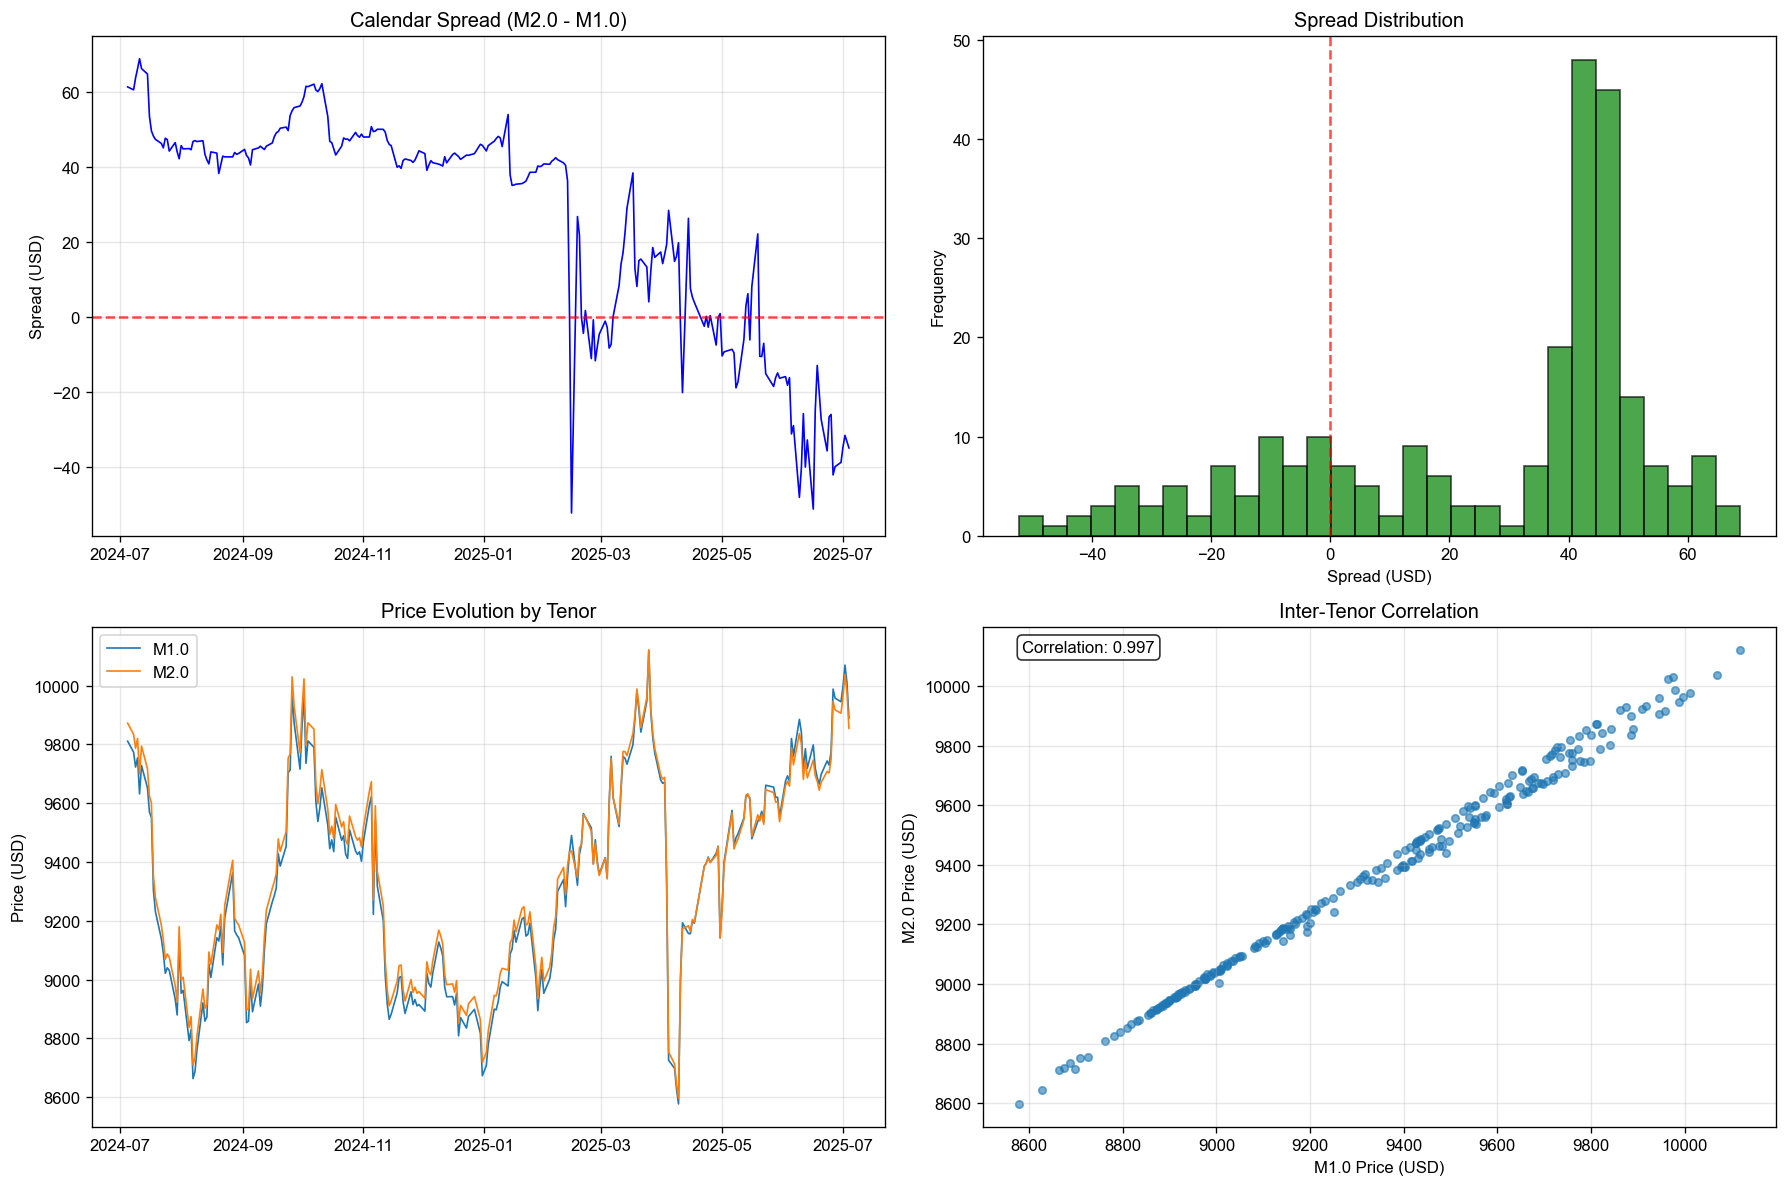

In [ ]:
# スプレッド分析
if len(available_tenors) >= 2:
    near_month = available_tenors[0]
    far_month = available_tenors[1] if len(
        available_tenors) > 1 else available_tenors[0]

    print(f"スプレッド分析: M{near_month} vs M{far_month}")

    # スプレッド計算（遠限月 - 近限月）
    if near_month in price_pivot.columns and far_month in price_pivot.columns:
        spread = price_pivot[far_month] - price_pivot[near_month]
        spread = spread.dropna()

        # スプレッドの統計量
        if len(spread) > 0:
            spread_stats = {
                'Mean': spread.mean(),
                'Std Dev': spread.std(),
                'Max': spread.max(),
                'Min': spread.min(),
                'Sharpe Ratio': spread.mean() / spread.std() if spread.std() != 0 else 0
            }

            print(f"\nスプレッド統計 (M{far_month} - M{near_month}):")
            for key, value in spread_stats.items():
                print(f"{key}: {value:.2f}")

            # 可視化
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))

            # 1. スプレッドの時系列
            axes[0, 0].plot(spread.index, spread.values,
                            linewidth=1, color='blue')
            axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
            axes[0, 0].set_title(
                f'Calendar Spread (M{far_month} - M{near_month})')
            axes[0, 0].set_ylabel('Spread (USD)')
            axes[0, 0].grid(True, alpha=0.3)

            # 2. スプレッドの分布
            axes[0, 1].hist(spread.values, bins=30, alpha=0.7,
                            color='green', edgecolor='black')
            axes[0, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7)
            axes[0, 1].set_title('Spread Distribution')
            axes[0, 1].set_xlabel('Spread (USD)')
            axes[0, 1].set_ylabel('Frequency')

            # 3. 価格の時系列比較
            if len(price_pivot[near_month].dropna()) > 0 and len(price_pivot[far_month].dropna()) > 0:
                axes[1, 0].plot(
                    price_pivot.index, price_pivot[near_month], label=f'M{near_month}', linewidth=1)
                axes[1, 0].plot(
                    price_pivot.index, price_pivot[far_month], label=f'M{far_month}', linewidth=1)
                axes[1, 0].set_title('Price Evolution by Tenor')
                axes[1, 0].set_ylabel('Price (USD)')
                axes[1, 0].legend()
                axes[1, 0].grid(True, alpha=0.3)

            # 4. 相関散布図
            common_dates = price_pivot.dropna(subset=[near_month, far_month])
            if len(common_dates) > 0:
                axes[1, 1].scatter(common_dates[near_month],
                                   common_dates[far_month], alpha=0.6, s=20)
                axes[1, 1].set_xlabel(f'M{near_month} Price (USD)')
                axes[1, 1].set_ylabel(f'M{far_month} Price (USD)')
                axes[1, 1].set_title('Inter-Tenor Correlation')

                # 相関係数の計算
                correlation = common_dates[near_month].corr(
                    common_dates[far_month])
                axes[1, 1].text(0.05, 0.95, f'Correlation: {correlation:.3f}',
                                transform=axes[1, 1].transAxes,
                                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                axes[1, 1].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()
        else:
            print("スプレッド計算に十分なデータがありません")
    else:
        print(f"必要な限月データが不足しています: M{near_month}, M{far_month}")
else:
    print("スプレッド分析には少なくとも2つの限月が必要です")

## 2. 季節性・循環性分析

### 分析目的
銅価格の季節的パターンや循環性を特定し、予測可能な価格変動を捉えて取引戦略に活用します。農産物とは異なり、銅などの金属商品でも季節性が存在する場合があります。

### 分析手法
- **月別リターン分析**: 各月の平均リターンを計算し季節的偏りを検証
- **曜日効果検証**: 特定の曜日に異常なリターンがないかを確認
- **四半期別分析**: 四半期ごとのリターン分布の違いを分析
- **年次比較**: 年毎の月次累積リターンパターンを比較

### グラフの見方・解釈
- **月別リターン**: 特定の月で一貫して高い/低いリターンがあれば季節性の証拠
- **曜日効果**: 月曜日や金曜日に偏りがあれば週末効果の存在を示唆
- **四半期パターン**: 企業決算期や需要サイクルの影響を反映
- **年次比較**: パターンの一貫性や市場環境による変化を確認

季節性分析対象: M1.0 (データ数: 253件)


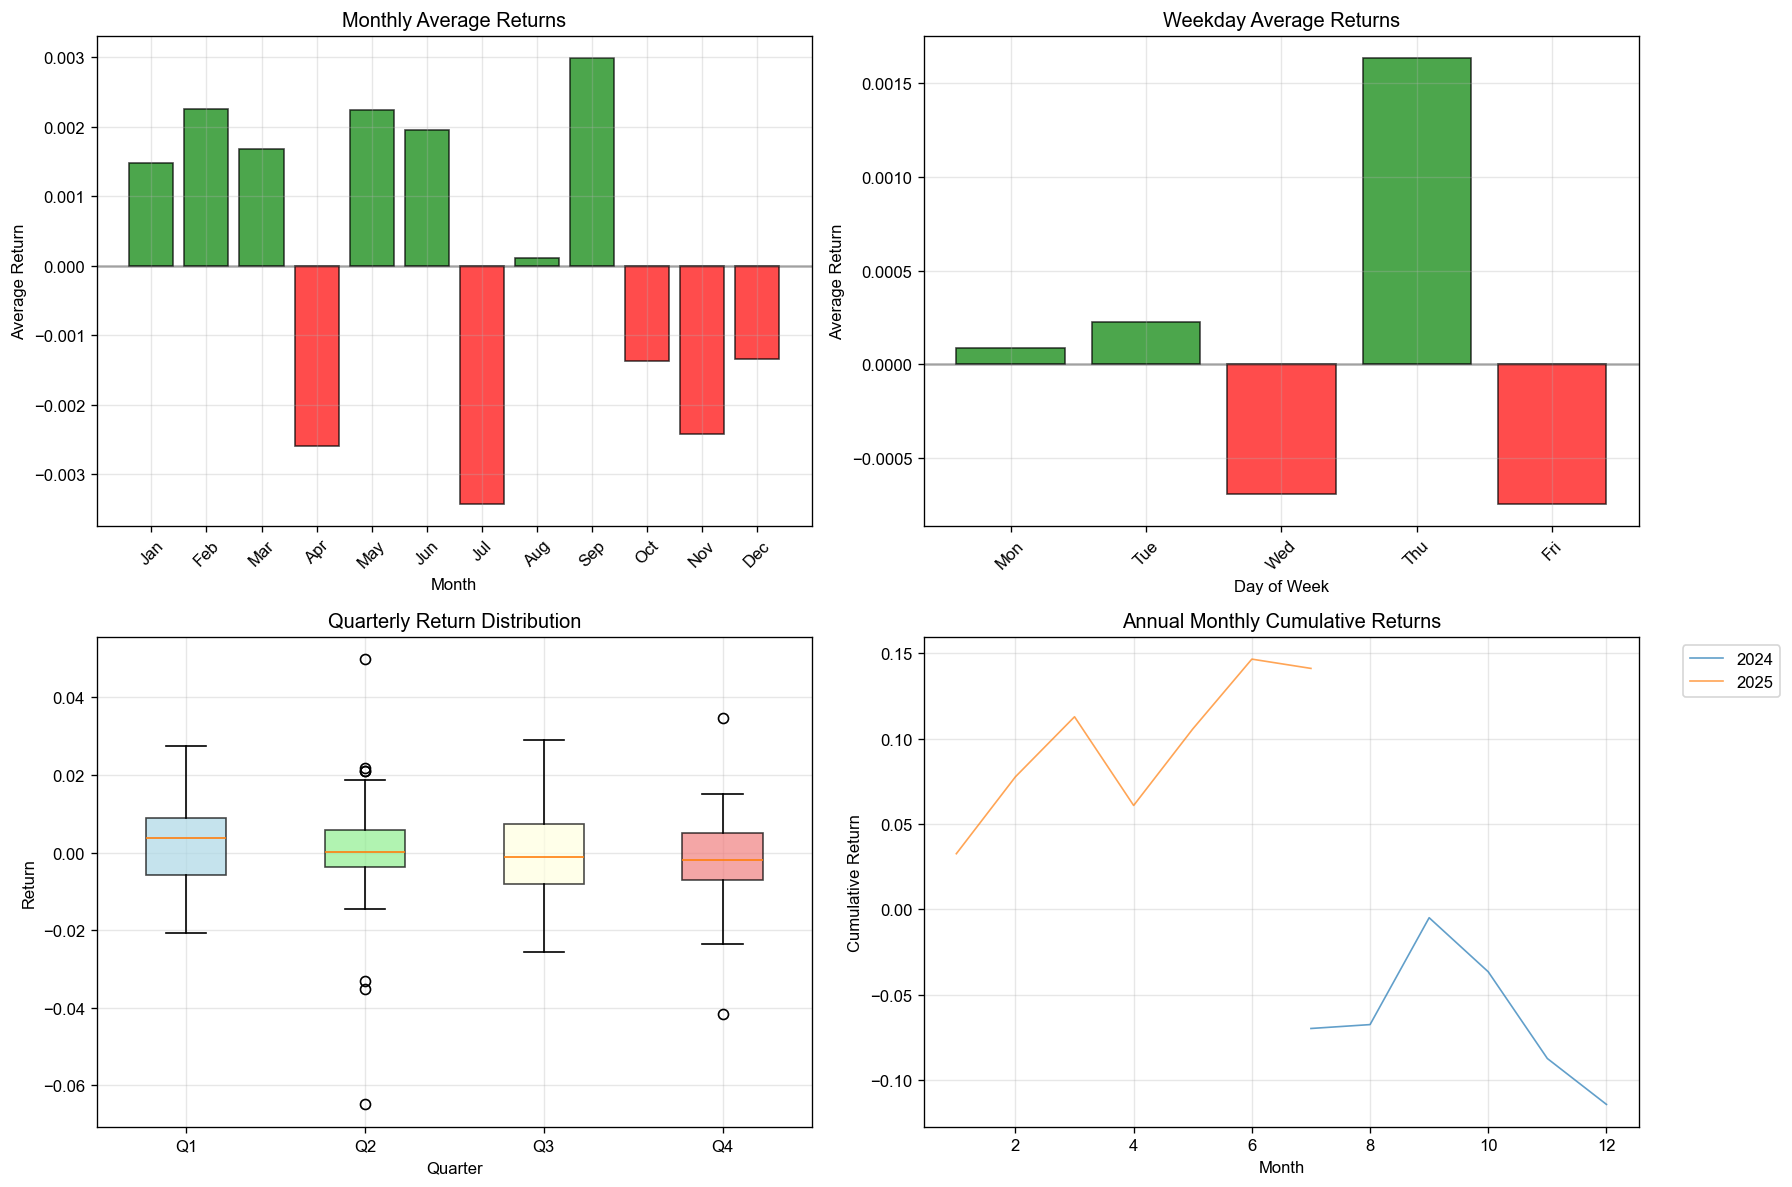


季節性分析結果:
最高月次平均リターン: Sep (0.0030)
最低月次平均リターン: Jul (-0.0034)
最高曜日平均リターン: Thu (0.0016)
最低曜日平均リターン: Fri (-0.0007)


In [ ]:
# 季節性分析
if len(available_tenors) > 0:
    # 主要限月を使用
    main_tenor = available_tenors[0]
    price_series = price_pivot[main_tenor].dropna()

    print(f"季節性分析対象: M{main_tenor} (データ数: {len(price_series)}件)")

    if len(price_series) > 30:  # 最小限必要なデータ数
        # 日次リターンの計算
        returns = price_series.pct_change().dropna()

        # 月・曜日・四半期の情報を追加
        returns_df = pd.DataFrame({
            'returns': returns,
            'month': returns.index.month,
            'weekday': returns.index.weekday,
            'quarter': returns.index.quarter,
            'year': returns.index.year
        })

        # 可視化
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # 1. 月別平均リターン
        monthly_returns = returns_df.groupby('month')['returns'].mean()
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

        # 月別データが存在する月のみプロット
        months_with_data = monthly_returns.index
        month_values = monthly_returns.values

        bars1 = axes[0, 0].bar(months_with_data, month_values,
                               color=['red' if x <
                                      0 else 'green' for x in month_values],
                               alpha=0.7, edgecolor='black')
        axes[0, 0].set_title('Monthly Average Returns')
        axes[0, 0].set_xlabel('Month')
        axes[0, 0].set_ylabel('Average Return')
        axes[0, 0].set_xticks(months_with_data)
        axes[0, 0].set_xticklabels([month_names[i-1]
                                   for i in months_with_data], rotation=45)
        axes[0, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[0, 0].grid(True, alpha=0.3)

        # 2. 曜日別平均リターン
        weekday_returns = returns_df.groupby('weekday')['returns'].mean()
        weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

        weekdays_with_data = weekday_returns.index
        weekday_values = weekday_returns.values

        bars2 = axes[0, 1].bar(weekdays_with_data, weekday_values,
                               color=['red' if x <
                                      0 else 'green' for x in weekday_values],
                               alpha=0.7, edgecolor='black')
        axes[0, 1].set_title('Weekday Average Returns')
        axes[0, 1].set_xlabel('Day of Week')
        axes[0, 1].set_ylabel('Average Return')
        axes[0, 1].set_xticks(weekdays_with_data)
        axes[0, 1].set_xticklabels([weekday_names[i]
                                   for i in weekdays_with_data], rotation=45)
        axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[0, 1].grid(True, alpha=0.3)

        # 3. 四半期別リターン分布
        quarters_with_data = sorted(returns_df['quarter'].unique())
        quarter_data = [returns_df[returns_df['quarter'] == q]
                        ['returns'].values for q in quarters_with_data]
        quarter_labels = [f'Q{q}' for q in quarters_with_data]

        if len(quarter_data) > 0 and any(len(data) > 0 for data in quarter_data):
            bp = axes[1, 0].boxplot([data for data in quarter_data if len(data) > 0],
                                    labels=[quarter_labels[i] for i, data in enumerate(
                                        quarter_data) if len(data) > 0],
                                    patch_artist=True)

            # ボックスプロットの色分け
            colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)

        axes[1, 0].set_title('Quarterly Return Distribution')
        axes[1, 0].set_xlabel('Quarter')
        axes[1, 0].set_ylabel('Return')
        axes[1, 0].grid(True, alpha=0.3)

        # 4. 累積リターンの季節性
        yearly_cumulative = returns_df.groupby(['year', 'month'])[
            'returns'].sum().reset_index()
        yearly_pivot = yearly_cumulative.pivot(
            index='month', columns='year', values='returns')

        for year in yearly_pivot.columns:
            if not yearly_pivot[year].isna().all():
                valid_data = yearly_pivot[year].dropna()
                if len(valid_data) > 0:
                    axes[1, 1].plot(valid_data.index, valid_data.cumsum(),
                                    label=str(year), alpha=0.7, linewidth=1)

        axes[1, 1].set_title('Annual Monthly Cumulative Returns')
        axes[1, 1].set_xlabel('Month')
        axes[1, 1].set_ylabel('Cumulative Return')
        axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # 統計的検定結果
        print("\n季節性分析結果:")
        if len(monthly_returns) > 0:
            best_month_idx = monthly_returns.idxmax()
            worst_month_idx = monthly_returns.idxmin()
            print(
                f"最高月次平均リターン: {month_names[best_month_idx-1]} ({monthly_returns.max():.4f})")
            print(
                f"最低月次平均リターン: {month_names[worst_month_idx-1]} ({monthly_returns.min():.4f})")

        if len(weekday_returns) > 0:
            best_weekday_idx = weekday_returns.idxmax()
            worst_weekday_idx = weekday_returns.idxmin()
            print(
                f"最高曜日平均リターン: {weekday_names[best_weekday_idx]} ({weekday_returns.max():.4f})")
            print(
                f"最低曜日平均リターン: {weekday_names[worst_weekday_idx]} ({weekday_returns.min():.4f})")
    else:
        print("季節性分析に十分なデータがありません")
else:
    print("季節性分析に使用可能なデータがありません")

## 3. 相関構造分析

### 分析目的
異なる限月間の相関関係を詳細に分析し、ポートフォリオのリスク管理と分散投資効果を評価します。市場ストレス時の相関変化も監視します。

### 分析手法
- **静的相関分析**: 限月間の相関行列を計算し全体的な関係性を把握
- **動的相関分析**: 30日ローリング相関で時間的変化を追跡
- **主成分分析**: 限月数を削減して主要な価格変動要因を特定
- **相関分布分析**: 相関係数の分布特性を統計的に評価

### グラフの見方・解釈
- **高相関（>0.8）**: 限月間の価格連動性が高く、分散効果は限定的
- **中程度相関（0.5-0.8）**: 適度な分散効果が期待できる
- **低相関（<0.5）**: 強い分散投資効果が期待できる
- **相関の時間変化**: 市場ストレス時に相関が上昇する傾向に注意
- **第1主成分の寄与率**: 市場全体の共通要因の強さを示す

相関分析対象限月: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 9.0, 10.0, 11.0, 12.0]


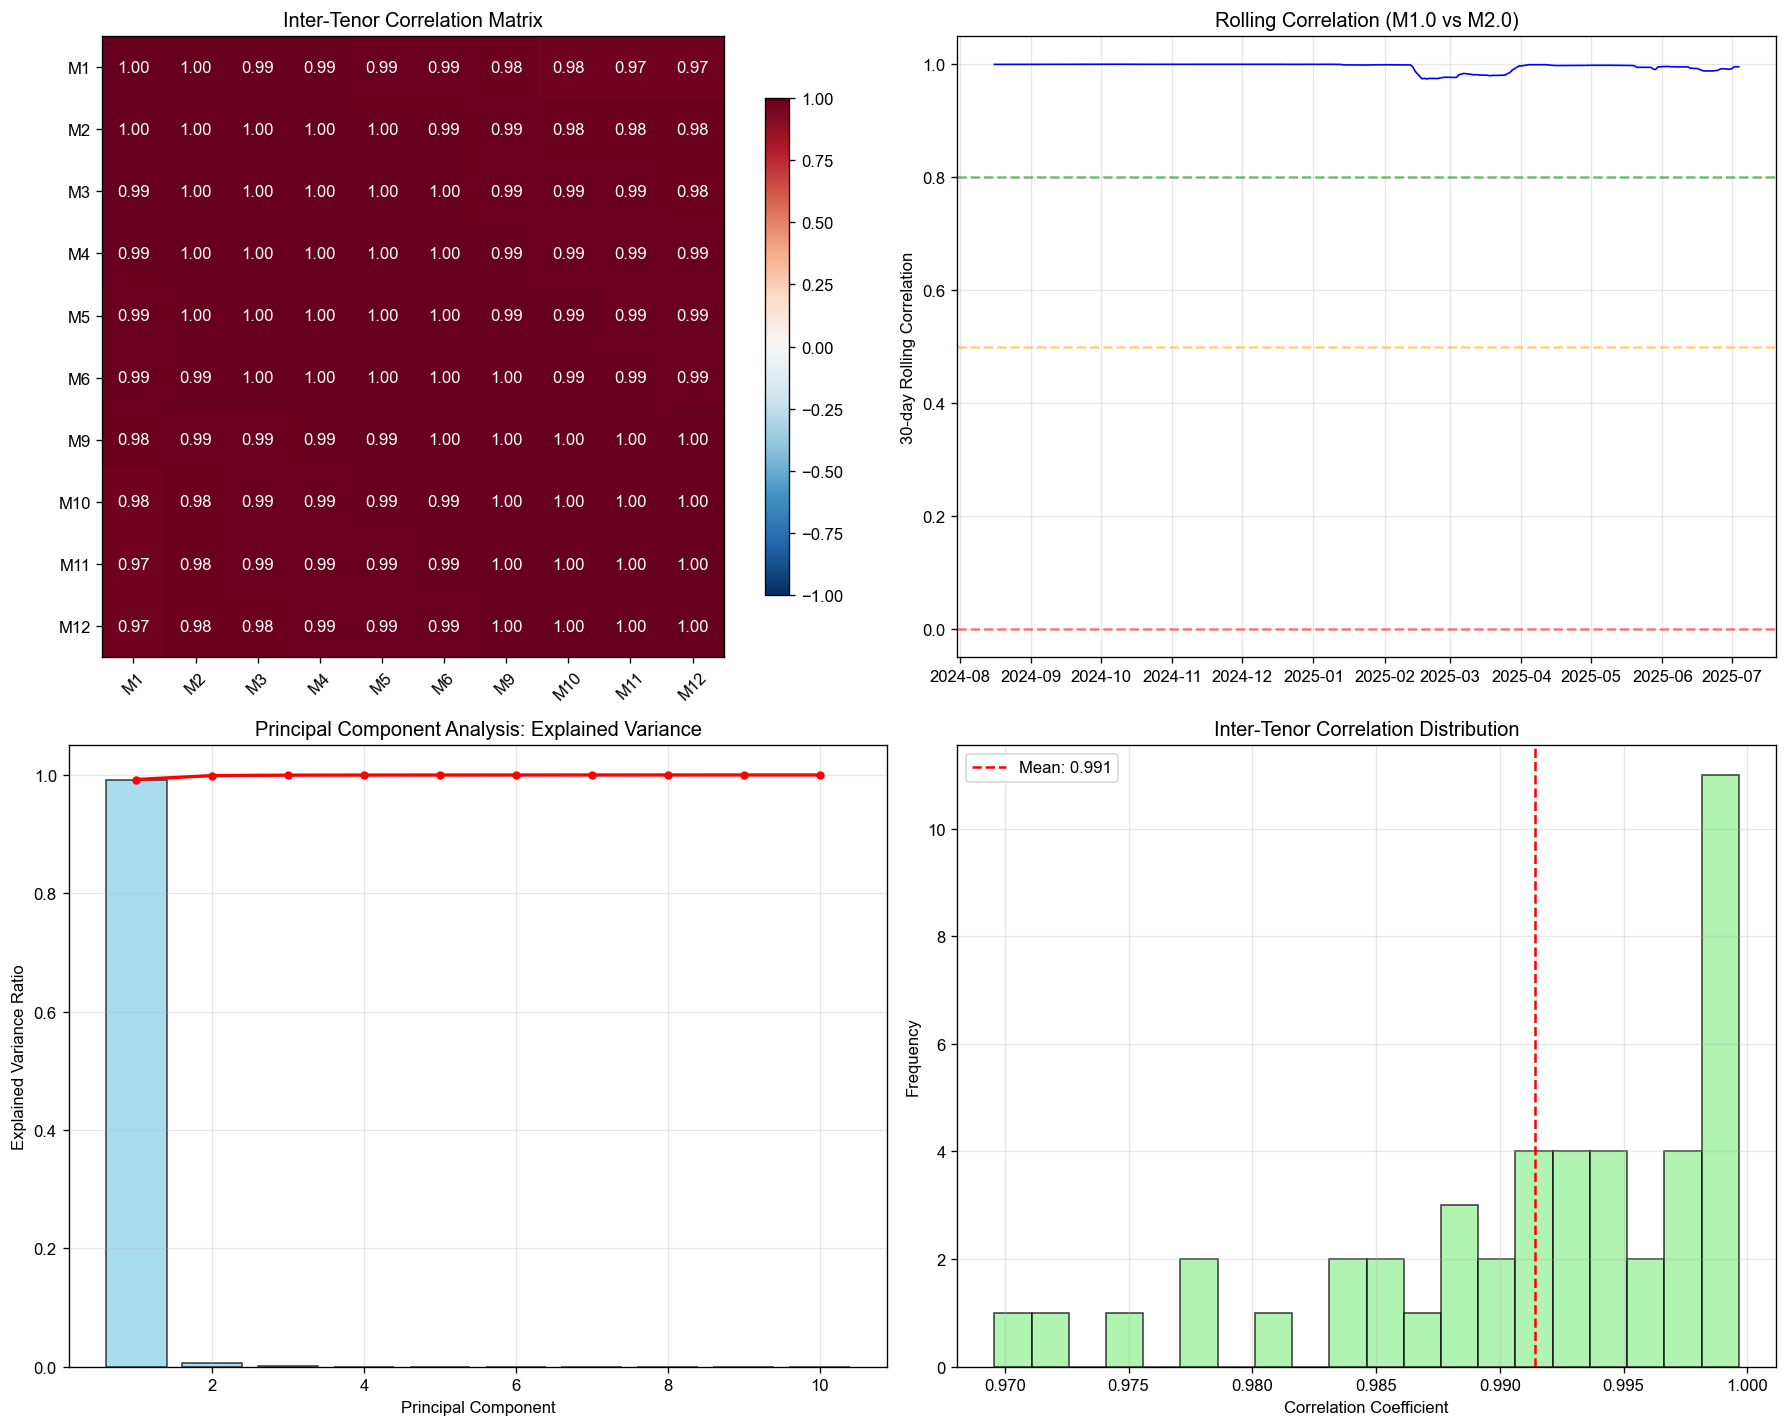


相関分析結果:
平均相関係数: 0.991
最大相関係数: 1.000
最小相関係数: 0.970
第1主成分の寄与率: 0.992
第2主成分の寄与率: 0.007


In [ ]:
# 相関分析
if len(available_tenors) >= 2:
    print(f"相関分析対象限月: {available_tenors}")

    # 各限月の日次リターンを計算
    returns_matrix = price_pivot.pct_change().dropna()

    if len(returns_matrix) > 30:  # 最小限必要なデータ数
        # 相関行列の計算
        correlation_matrix = returns_matrix.corr()

        # 可視化
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. 相関行列のヒートマップ
        im1 = axes[0, 0].imshow(
            correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
        axes[0, 0].set_title('Inter-Tenor Correlation Matrix')
        axes[0, 0].set_xticks(range(len(correlation_matrix.columns)))
        axes[0, 0].set_yticks(range(len(correlation_matrix.columns)))
        axes[0, 0].set_xticklabels(
            [f'M{int(col)}' for col in correlation_matrix.columns], rotation=45)
        axes[0, 0].set_yticklabels(
            [f'M{int(col)}' for col in correlation_matrix.columns])

        # 相関係数をテキストで表示
        for i in range(len(correlation_matrix.columns)):
            for j in range(len(correlation_matrix.columns)):
                value = correlation_matrix.iloc[i, j]
                if not np.isnan(value):
                    text = axes[0, 0].text(j, i, f'{value:.2f}',
                                           ha='center', va='center',
                                           color='white' if abs(value) > 0.5 else 'black')

        plt.colorbar(im1, ax=axes[0, 0], shrink=0.8)

        # 2. 動的相関（ローリング相関）- 最初の2つの限月
        if len(available_tenors) >= 2:
            tenor1, tenor2 = available_tenors[0], available_tenors[1]
            if tenor1 in returns_matrix.columns and tenor2 in returns_matrix.columns:
                rolling_corr = returns_matrix[tenor1].rolling(
                    window=30).corr(returns_matrix[tenor2]).dropna()

                if len(rolling_corr) > 0:
                    axes[0, 1].plot(
                        rolling_corr.index, rolling_corr.values, linewidth=1, color='blue')
                    axes[0, 1].set_title(
                        f'Rolling Correlation (M{tenor1} vs M{tenor2})')
                    axes[0, 1].set_ylabel('30-day Rolling Correlation')
                    axes[0, 1].axhline(
                        y=0, color='red', linestyle='--', alpha=0.5)
                    axes[0, 1].axhline(y=0.5, color='orange',
                                       linestyle='--', alpha=0.5)
                    axes[0, 1].axhline(y=0.8, color='green',
                                       linestyle='--', alpha=0.5)
                    axes[0, 1].grid(True, alpha=0.3)

        # 3. 主成分分析
        try:
            from sklearn.decomposition import PCA
            from sklearn.preprocessing import StandardScaler

            # データの標準化
            scaler = StandardScaler()
            returns_clean = returns_matrix.dropna()

            if len(returns_clean) > 0:
                returns_scaled = scaler.fit_transform(returns_clean)

                # PCA実行
                pca = PCA()
                pca.fit(returns_scaled)

                # 寄与率の可視化
                explained_variance = pca.explained_variance_ratio_
                cumulative_variance = np.cumsum(explained_variance)

                axes[1, 0].bar(range(1, len(explained_variance) + 1), explained_variance,
                               alpha=0.7, color='skyblue', edgecolor='black')
                axes[1, 0].plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
                                color='red', marker='o', linewidth=2, markersize=4)
                axes[1, 0].set_title(
                    'Principal Component Analysis: Explained Variance')
                axes[1, 0].set_xlabel('Principal Component')
                axes[1, 0].set_ylabel('Explained Variance Ratio')
                axes[1, 0].grid(True, alpha=0.3)

                pca_available = True
            else:
                pca_available = False

        except (ImportError, ValueError):
            axes[1, 0].text(0.5, 0.5, 'PCA analysis\nnot available',
                            ha='center', va='center', transform=axes[1, 0].transAxes)
            axes[1, 0].set_title('Principal Component Analysis: Not Available')
            pca_available = False

        # 4. 相関の分布
        # 上三角行列の相関係数を取得
        upper_triangle = correlation_matrix.where(
            np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
        correlations = upper_triangle.stack().values
        correlations = correlations[~np.isnan(correlations)]  # NaN値を除去

        if len(correlations) > 0:
            axes[1, 1].hist(correlations, bins=20, alpha=0.7,
                            color='lightgreen', edgecolor='black')
            axes[1, 1].axvline(x=np.mean(correlations), color='red', linestyle='--',
                               label=f'Mean: {np.mean(correlations):.3f}')
            axes[1, 1].set_title('Inter-Tenor Correlation Distribution')
            axes[1, 1].set_xlabel('Correlation Coefficient')
            axes[1, 1].set_ylabel('Frequency')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # 統計サマリー
        print("\n相関分析結果:")
        if len(correlations) > 0:
            print(f"平均相関係数: {np.mean(correlations):.3f}")
            print(f"最大相関係数: {np.max(correlations):.3f}")
            print(f"最小相関係数: {np.min(correlations):.3f}")

        if pca_available and 'explained_variance' in locals():
            print(f"第1主成分の寄与率: {explained_variance[0]:.3f}")
            if len(explained_variance) > 1:
                print(f"第2主成分の寄与率: {explained_variance[1]:.3f}")

    else:
        print("相関分析に十分なデータがありません")
else:
    print("相関分析には少なくとも2つの限月が必要です")

## 4. リスク・パリティ分析

### 分析目的
各限月のリスク貢献度を均等化したポートフォリオを構築し、単純な均等ウェイトと比較してリスク調整後のパフォーマンスを最適化します。

### 分析手法
- **ボラティリティ計算**: 各限月の年率換算ボラティリティを算出
- **リスク・パリティ・ウェイト**: 逆ボラティリティによる重み付け
- **ポートフォリオ・バックテスト**: 等ウェイトとリスク・パリティの比較
- **パフォーマンス指標**: シャープレシオ、最大ドローダウン等の計算

### グラフの見方・解釈
- **ウェイト比較**: リスク・パリティでは低ボラ資産に高いウェイト
- **累積リターン**: 長期的なパフォーマンスの安定性を評価
- **ドローダウン**: 最大損失期間とその深さを比較
- **リスク・リターン散布図**: 効率的フロンティア上のポジション確認
- **個別限月**: 単独投資との比較でポートフォリオ効果を確認

リスク・パリティ分析対象: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 9.0, 10.0, 11.0, 12.0]


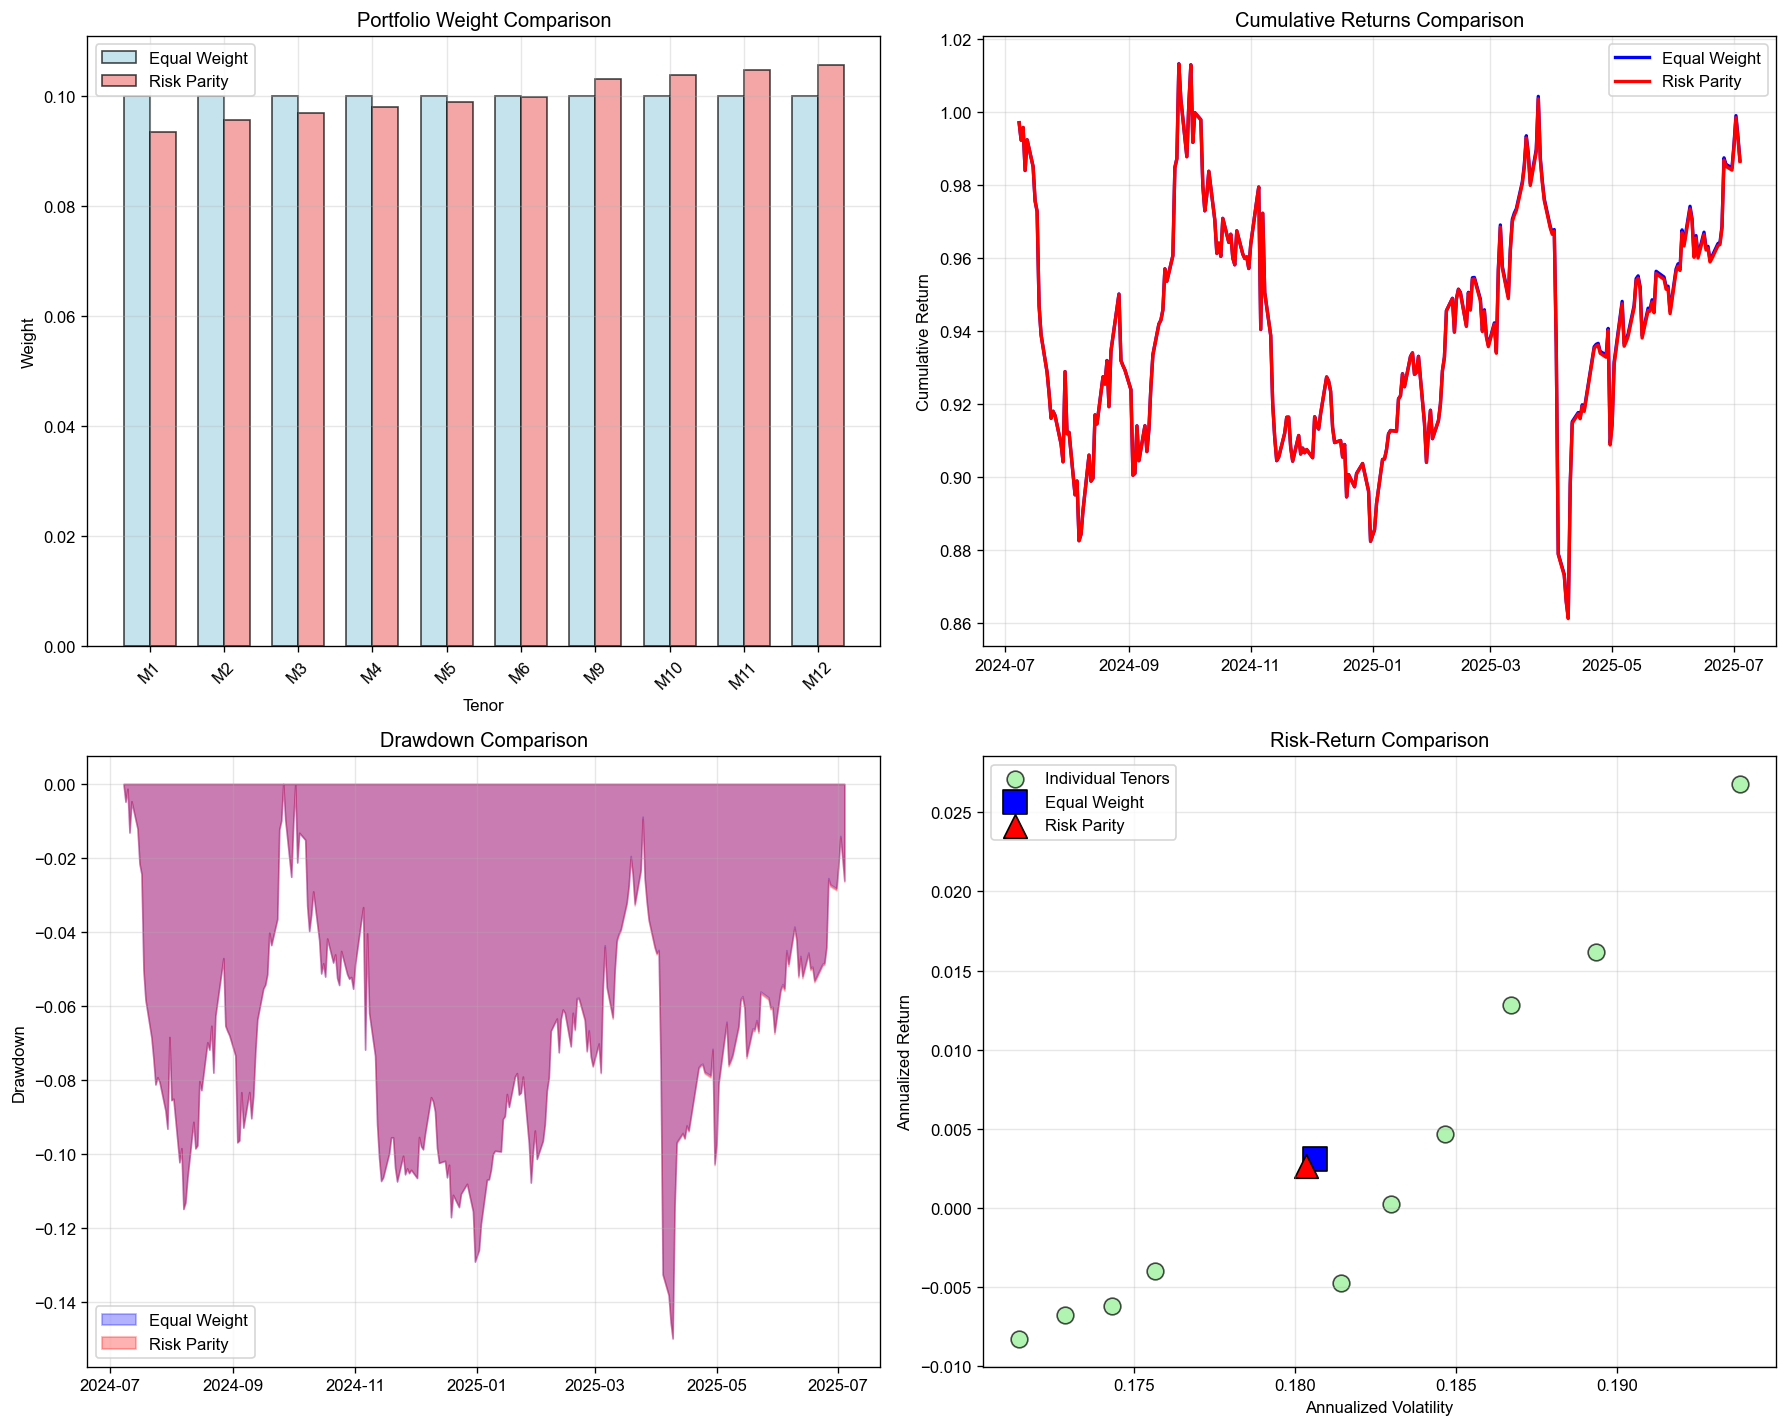


ポートフォリオ・パフォーマンス比較:

均等ウェイト:
  Annual Return: 0.0031
  Annual Volatility: 0.1806
  Sharpe Ratio: 0.0171
  Max Drawdown: -0.1499

リスク・パリティ:
  Annual Return: 0.0027
  Annual Volatility: 0.1803
  Sharpe Ratio: 0.0148
  Max Drawdown: -0.1501

個別限月ボラティリティ:
  M1.0: 0.1938
  M2.0: 0.1893
  M3.0: 0.1867
  M4.0: 0.1847
  M5.0: 0.1830
  M6.0: 0.1814
  M9.0: 0.1756
  M10.0: 0.1743
  M11.0: 0.1729
  M12.0: 0.1714


In [ ]:
# リスク・パリティ分析
if len(available_tenors) >= 2:
    print(f"リスク・パリティ分析対象: {available_tenors}")

    # 各限月のリターンとボラティリティを計算
    returns_clean = returns_matrix.dropna()

    if len(returns_clean) > 50:  # 最小限必要なデータ数
        # 各限月のボラティリティ（年率化）
        volatilities = returns_clean.std() * np.sqrt(252)
        volatilities = volatilities.dropna()

        if len(volatilities) >= 2:
            # リスク・パリティ・ウェイト（逆ボラティリティ）
            inverse_vol = 1 / volatilities
            risk_parity_weights = inverse_vol / inverse_vol.sum()

            # 均等ウェイト
            equal_weights = pd.Series(
                index=volatilities.index, data=1/len(volatilities))

            # ポートフォリオリターンの計算
            returns_for_portfolio = returns_clean[volatilities.index]
            equal_weighted_returns = (
                returns_for_portfolio * equal_weights).sum(axis=1)
            risk_parity_returns = (
                returns_for_portfolio * risk_parity_weights).sum(axis=1)

            # 累積リターンの計算
            equal_weighted_cumulative = (1 + equal_weighted_returns).cumprod()
            risk_parity_cumulative = (1 + risk_parity_returns).cumprod()

            # ドローダウンの計算
            def calculate_drawdown(returns):
                cumulative = (1 + returns).cumprod()
                running_max = cumulative.expanding().max()
                drawdown = (cumulative - running_max) / running_max
                return drawdown

            equal_weighted_dd = calculate_drawdown(equal_weighted_returns)
            risk_parity_dd = calculate_drawdown(risk_parity_returns)

            # 可視化
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))

            # 1. ウェイトの比較
            x = np.arange(len(volatilities))
            width = 0.35

            bars1 = axes[0, 0].bar(x - width/2, equal_weights.values, width, label='Equal Weight',
                                   alpha=0.7, color='lightblue', edgecolor='black')
            bars2 = axes[0, 0].bar(x + width/2, risk_parity_weights.values, width, label='Risk Parity',
                                   alpha=0.7, color='lightcoral', edgecolor='black')

            axes[0, 0].set_title('Portfolio Weight Comparison')
            axes[0, 0].set_xlabel('Tenor')
            axes[0, 0].set_ylabel('Weight')
            axes[0, 0].set_xticks(x)
            axes[0, 0].set_xticklabels(
                [f'M{int(t)}' for t in volatilities.index], rotation=45)
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)

            # 2. 累積リターンの比較
            axes[0, 1].plot(equal_weighted_cumulative.index, equal_weighted_cumulative.values,
                            label='Equal Weight', linewidth=2, color='blue')
            axes[0, 1].plot(risk_parity_cumulative.index, risk_parity_cumulative.values,
                            label='Risk Parity', linewidth=2, color='red')
            axes[0, 1].set_title('Cumulative Returns Comparison')
            axes[0, 1].set_ylabel('Cumulative Return')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)

            # 3. ドローダウンの比較
            axes[1, 0].fill_between(equal_weighted_dd.index, equal_weighted_dd.values, 0,
                                    alpha=0.3, color='blue', label='Equal Weight')
            axes[1, 0].fill_between(risk_parity_dd.index, risk_parity_dd.values, 0,
                                    alpha=0.3, color='red', label='Risk Parity')
            axes[1, 0].set_title('Drawdown Comparison')
            axes[1, 0].set_ylabel('Drawdown')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)

            # 4. リスク・リターン散布図
            individual_returns = returns_for_portfolio.mean() * 252
            individual_vol = volatilities

            axes[1, 1].scatter(individual_vol, individual_returns, s=100, alpha=0.7,
                               c='lightgreen', edgecolor='black', label='Individual Tenors')

            # ポートフォリオのリスク・リターン
            equal_vol = equal_weighted_returns.std() * np.sqrt(252)
            equal_ret = equal_weighted_returns.mean() * 252
            rp_vol = risk_parity_returns.std() * np.sqrt(252)
            rp_ret = risk_parity_returns.mean() * 252

            axes[1, 1].scatter(equal_vol, equal_ret, s=200, color='blue',
                               edgecolor='black', label='Equal Weight', marker='s')
            axes[1, 1].scatter(rp_vol, rp_ret, s=200, color='red',
                               edgecolor='black', label='Risk Parity', marker='^')

            axes[1, 1].set_xlabel('Annualized Volatility')
            axes[1, 1].set_ylabel('Annualized Return')
            axes[1, 1].set_title('Risk-Return Comparison')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            # パフォーマンス統計
            def calculate_performance_metrics(returns):
                annual_return = returns.mean() * 252
                annual_vol = returns.std() * np.sqrt(252)
                sharpe_ratio = annual_return / annual_vol if annual_vol != 0 else 0
                max_drawdown = calculate_drawdown(returns).min()
                return {
                    'Annual Return': annual_return,
                    'Annual Volatility': annual_vol,
                    'Sharpe Ratio': sharpe_ratio,
                    'Max Drawdown': max_drawdown
                }

            equal_metrics = calculate_performance_metrics(
                equal_weighted_returns)
            rp_metrics = calculate_performance_metrics(risk_parity_returns)

            print("\nポートフォリオ・パフォーマンス比較:")
            print("\n均等ウェイト:")
            for key, value in equal_metrics.items():
                print(f"  {key}: {value:.4f}")

            print("\nリスク・パリティ:")
            for key, value in rp_metrics.items():
                print(f"  {key}: {value:.4f}")

            print("\n個別限月ボラティリティ:")
            for tenor, vol in volatilities.items():
                print(f"  M{tenor}: {vol:.4f}")
        else:
            print("リスク・パリティ分析に十分な限月データがありません")
    else:
        print("リスク・パリティ分析に十分な時系列データがありません")
else:
    print("リスク・パリティ分析には少なくとも2つの限月が必要です")

## 5. 異常検知・レジーム分析

### 分析目的
市場の異常な動きや構造的な変化（レジームチェンジ）を早期に検出し、リスク管理の改善とトレーディング機会の発見を図ります。

### 分析手法
- **統計的異常検知**: Z-スコア法とIQR法による外れ値の特定
- **ボラティリティ・レジーム**: 30日ローリング・ボラティリティによる市場環境分類
- **価格レベル分析**: 異常値発生時の価格水準の確認
- **分布分析**: 正常時と異常時のリターン分布の比較

### グラフの見方・解釈
- **異常値（赤点）**: Z-スコア>3.0の極端な価格変動
- **IQR異常値（オレンジ×）**: 四分位範囲を大きく超える変動
- **高ボラティリティ期間（赤背景）**: 市場不安定期、リスク拡大時期
- **低ボラティリティ期間（緑背景）**: 市場安定期、取引機会減少
- **価格での異常値マーク**: 実際の投資判断への影響を可視化

異常検知分析対象: M1.0 (データ数: 253件)


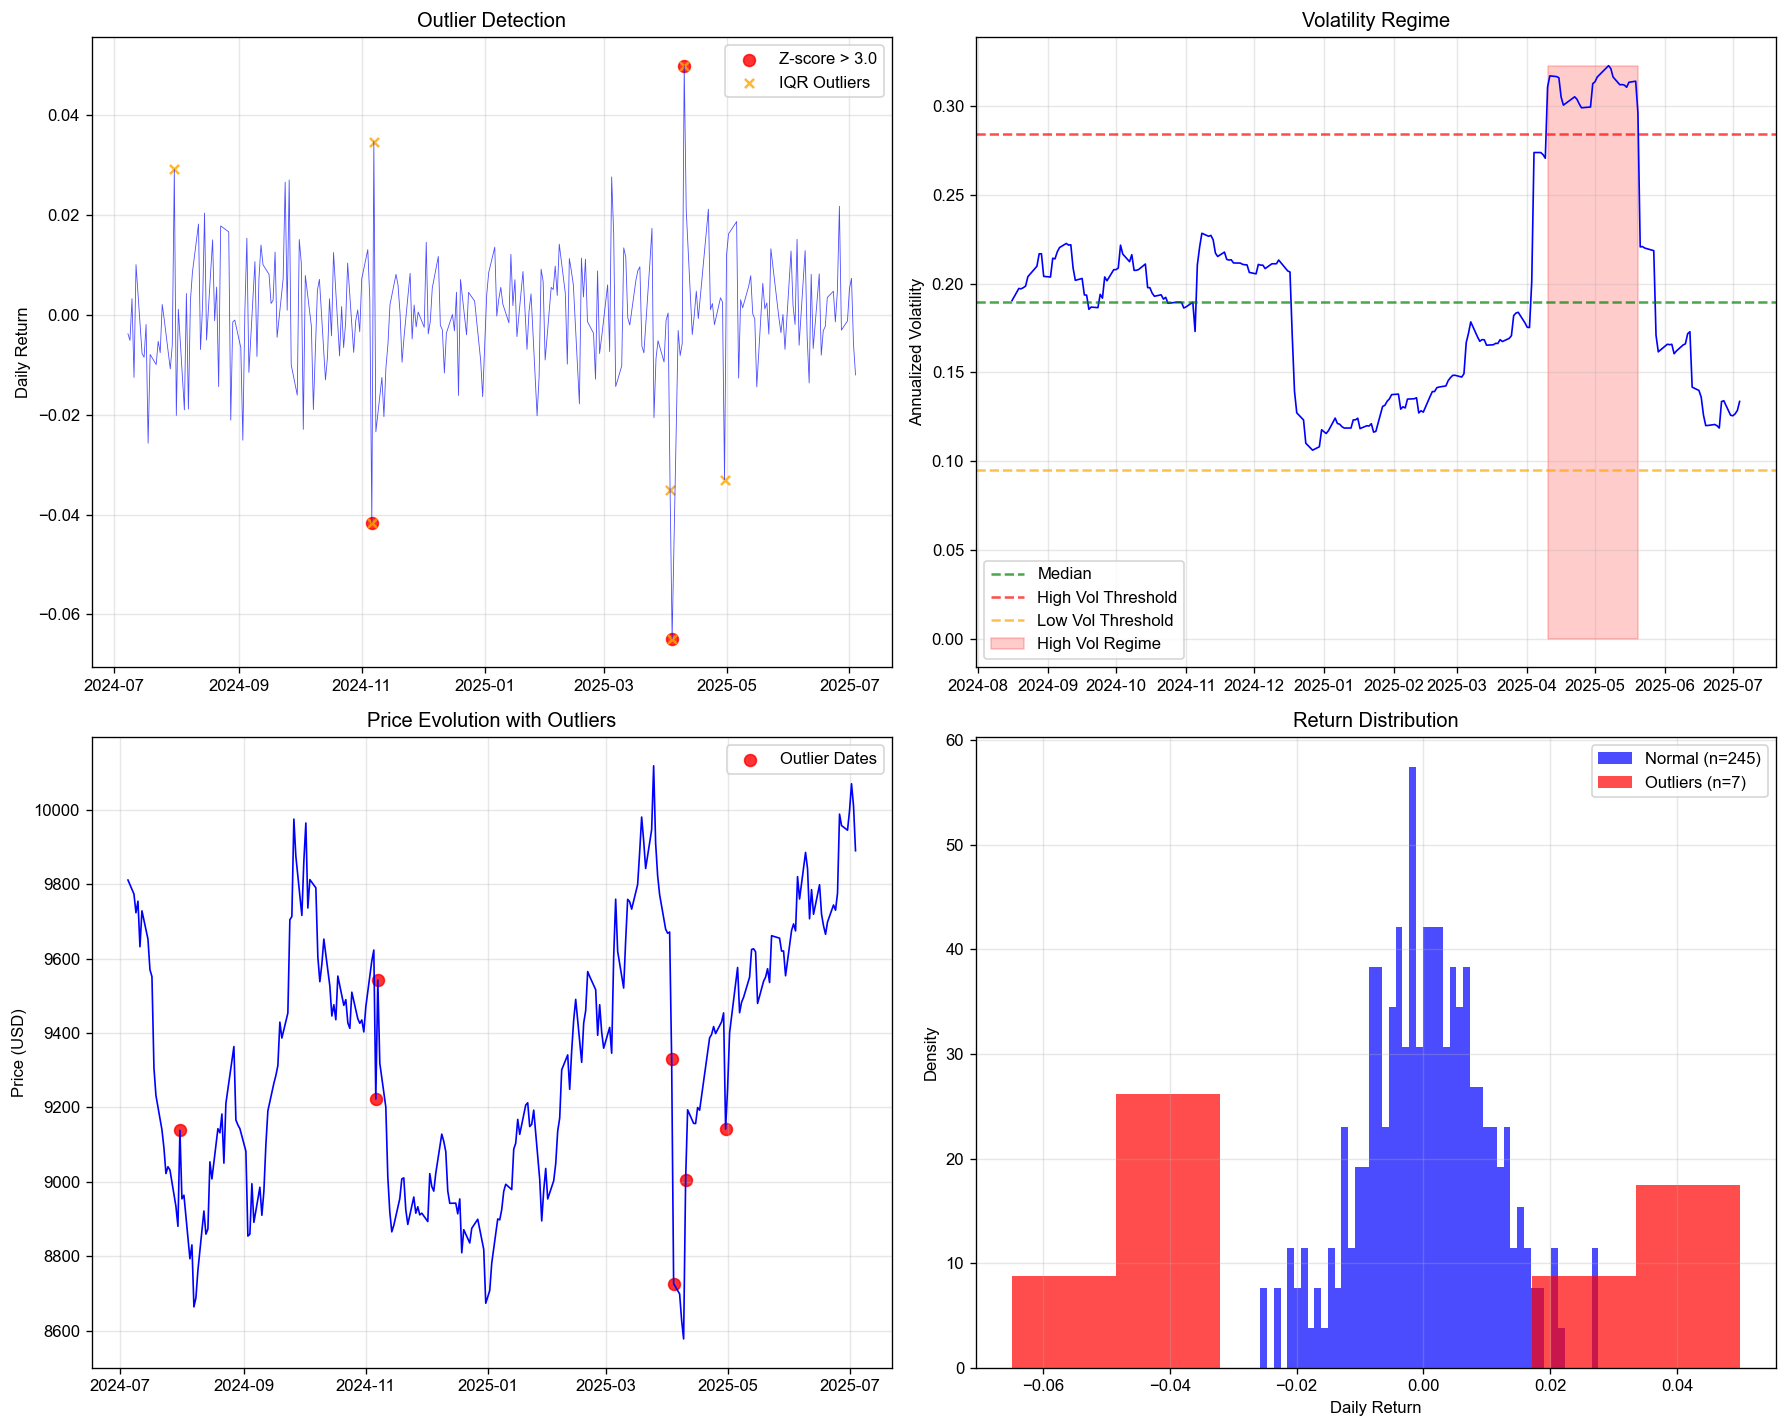


異常検知・レジーム分析結果:
Z-score異常値: 3件 (1.19%)
IQR異常値: 7件 (2.78%)
高ボラティリティ期間: 26日 (11.7%)
低ボラティリティ期間: 0日 (0.0%)
ボラティリティ中央値: 0.1895
最大ボラティリティ: 0.3227
最小ボラティリティ: 0.1062

最大異常値: 2025-04-04 (-0.0649)


In [ ]:
# 異常検知・レジーム分析
if len(available_tenors) > 0:
    main_tenor = available_tenors[0]
    price_series = price_pivot[main_tenor].dropna()

    print(f"異常検知分析対象: M{main_tenor} (データ数: {len(price_series)}件)")

    if len(price_series) > 50:
        returns = price_series.pct_change().dropna()

        # 1. 統計的異常検知
        # Z-スコア法
        z_scores = np.abs((returns - returns.mean()) / returns.std())
        z_threshold = 3.0
        z_outliers = z_scores > z_threshold

        # IQR法
        Q1 = returns.quantile(0.25)
        Q3 = returns.quantile(0.75)
        IQR = Q3 - Q1
        iqr_outliers = (returns < (Q1 - 1.5 * IQR)
                        ) | (returns > (Q3 + 1.5 * IQR))

        # 2. ボラティリティ・レジーム検出
        # 30日ローリング・ボラティリティ
        rolling_vol = returns.rolling(window=30).std() * np.sqrt(252)
        rolling_vol = rolling_vol.dropna()

        if len(rolling_vol) > 0:
            vol_median = rolling_vol.median()

            # 高ボラティリティ期間と低ボラティリティ期間
            high_vol_regime = rolling_vol > vol_median * 1.5
            low_vol_regime = rolling_vol < vol_median * 0.5

            # 可視化
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))

            # 1. 異常値検出
            axes[0, 0].plot(returns.index, returns.values,
                            linewidth=0.5, color='blue', alpha=0.7)

            if z_outliers.sum() > 0:
                axes[0, 0].scatter(returns[z_outliers].index, returns[z_outliers].values,
                                   color='red', s=50, alpha=0.8, label=f'Z-score > {z_threshold}')

            if iqr_outliers.sum() > 0:
                axes[0, 0].scatter(returns[iqr_outliers].index, returns[iqr_outliers].values,
                                   color='orange', s=30, alpha=0.8, marker='x', label='IQR Outliers')

            axes[0, 0].set_title('Outlier Detection')
            axes[0, 0].set_ylabel('Daily Return')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)

            # 2. ボラティリティ・レジーム
            axes[0, 1].plot(rolling_vol.index, rolling_vol.values,
                            linewidth=1, color='blue')
            axes[0, 1].axhline(y=vol_median, color='green',
                               linestyle='--', alpha=0.7, label='Median')
            axes[0, 1].axhline(y=vol_median * 1.5, color='red',
                               linestyle='--', alpha=0.7, label='High Vol Threshold')
            axes[0, 1].axhline(y=vol_median * 0.5, color='orange',
                               linestyle='--', alpha=0.7, label='Low Vol Threshold')

            # レジームの背景色
            if high_vol_regime.sum() > 0:
                axes[0, 1].fill_between(rolling_vol.index, 0, rolling_vol.max(),
                                        where=high_vol_regime, alpha=0.2, color='red', label='High Vol Regime')

            if low_vol_regime.sum() > 0:
                axes[0, 1].fill_between(rolling_vol.index, 0, rolling_vol.max(),
                                        where=low_vol_regime, alpha=0.2, color='green', label='Low Vol Regime')

            axes[0, 1].set_title('Volatility Regime')
            axes[0, 1].set_ylabel('Annualized Volatility')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)

            # 3. 価格レベルと異常値
            axes[1, 0].plot(price_series.index,
                            price_series.values, linewidth=1, color='blue')

            # 異常値の日付における価格にマーク
            outlier_dates = returns[z_outliers | iqr_outliers].index
            if len(outlier_dates) > 0:
                outlier_prices = price_series.reindex(outlier_dates).dropna()
                if len(outlier_prices) > 0:
                    axes[1, 0].scatter(outlier_prices.index, outlier_prices.values,
                                       color='red', s=50, alpha=0.8, label='Outlier Dates')

            axes[1, 0].set_title('Price Evolution with Outliers')
            axes[1, 0].set_ylabel('Price (USD)')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)

            # 4. 異常値の分布
            normal_returns = returns[~(z_outliers | iqr_outliers)]
            outlier_returns = returns[z_outliers | iqr_outliers]

            if len(normal_returns) > 0:
                axes[1, 1].hist(normal_returns, bins=50, alpha=0.7, color='blue',
                                label=f'Normal (n={len(normal_returns)})', density=True)

            if len(outlier_returns) > 0:
                axes[1, 1].hist(outlier_returns, bins=min(20, len(outlier_returns)), alpha=0.7, color='red',
                                label=f'Outliers (n={len(outlier_returns)})', density=True)

            axes[1, 1].set_title('Return Distribution')
            axes[1, 1].set_xlabel('Daily Return')
            axes[1, 1].set_ylabel('Density')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            # 統計サマリー
            print("\n異常検知・レジーム分析結果:")
            print(
                f"Z-score異常値: {z_outliers.sum()}件 ({z_outliers.sum()/len(returns)*100:.2f}%)")
            print(
                f"IQR異常値: {iqr_outliers.sum()}件 ({iqr_outliers.sum()/len(returns)*100:.2f}%)")
            print(
                f"高ボラティリティ期間: {high_vol_regime.sum()}日 ({high_vol_regime.sum()/len(high_vol_regime)*100:.1f}%)")
            print(
                f"低ボラティリティ期間: {low_vol_regime.sum()}日 ({low_vol_regime.sum()/len(low_vol_regime)*100:.1f}%)")
            print(f"ボラティリティ中央値: {vol_median:.4f}")
            print(f"最大ボラティリティ: {rolling_vol.max():.4f}")
            print(f"最小ボラティリティ: {rolling_vol.min():.4f}")

            # 最も大きな異常値の日付
            if z_outliers.sum() > 0:
                max_outlier_date = returns[z_outliers].abs().idxmax()
                max_outlier_value = returns[max_outlier_date]
                print(
                    f"\n最大異常値: {max_outlier_date.strftime('%Y-%m-%d')} ({max_outlier_value:.4f})")
        else:
            print("ボラティリティ計算に十分なデータがありません")
    else:
        print("異常検知分析に十分なデータがありません")
else:
    print("異常検知分析に使用可能なデータがありません")

## 分析結果の総括

### 主要な発見
1. **スプレッド取引戦略**: 限月間の価格差は統計的な特性を持ち、平均回帰性が確認できれば裁定取引の機会が存在
2. **季節性パターン**: 特定の月や曜日に一貫した偏りがある場合、季節的な取引戦略が有効
3. **相関構造**: 限月間の相関は時間とともに変化し、市場ストレス時に上昇する傾向
4. **リスク管理**: リスク・パリティ戦略は均等ウェイトよりも安定したパフォーマンスを提供する可能性
5. **異常検知**: 統計的異常値の早期検出により、リスク管理とトレーディング機会の改善が可能

### 実践的な応用
- **ポートフォリオ構築**: リスク・パリティ・ウェイトの採用による安定化
- **リスク管理**: 異常値検出システムによる早期警告
- **取引戦略**: 季節性とスプレッドを組み合わせた体系的アプローチ
- **動的調整**: 市場レジームの変化に応じたポートフォリオの再調整
- **ボラティリティ・タイミング**: 高ボラ期間での取引量調整

### 重要な注意点
- **過去データの限界**: 将来のパフォーマンスを保証するものではない
- **市場環境の変化**: マクロ経済環境の変化で関係性が変わる可能性
- **取引コストの考慮**: 実際の取引では流動性コストとスプレッドを考慮必要
- **モデルリスク**: 統計モデルの前提条件が崩れるリスクの存在
- **レジーム変化**: 市場構造の変化により過去のパターンが継続しない可能性

この分析フレームワークを定期的に更新することで、最新の市場状況を反映した投資判断が可能になります。

In [8]:
# データベース接続を閉じる
conn.close()
print("\n分析完了。データベース接続を閉じました。")


分析完了。データベース接続を閉じました。
